# Levy-Lieb Procedure for Variational Quantum Eigensolvers - The Hubbard Dimer

In this notebook, we will calculate the ground state of a Hubbard dimer using the Levy-Lieb procedure. First consider an interacting-particle system described by the Hamiltonian,
\begin{equation*}
\hat{H} = \hat{T} + \hat{W} + \hat{v}
\end{equation*}

where $\hat{T}$, $\hat{W}$ are the kinetic and interaction potential operators and $\hat{v}$ is the external potential operator. The Levy-Lieb procedure relies on the Levy-Lieb density functional which is evaluated by minimizing the expectation:

\begin{equation*}
F_{LL}(t) = \langle \psi(t) | \hat{T} + \hat{W} | \psi(t) \rangle
\end{equation*}

Subject to the constraint 
\begin{equation*}
\|d\| \equiv \| \langle \Psi(t) | \hat{\mathbf{D}} | \Psi(t) \rangle\ \|  = 0
\end{equation*}

where  
\begin{equation*}
\mathbf{\hat{D}} \equiv \left[ \sum_{\sigma} \hat{c}^\dagger_{i\sigma} \hat{c}_{i\sigma} - n_i, \quad i = 1..M \right]
\end{equation*}

where $M$ is the size of the system. The value of $\mathbf{n}$ is varied to minimise $E(\mathbf{v}) = F_{LL} (\mathbf{v}) + \mathbf{v} . \mathbf{n}$ classically. At the optimum, $\mathbf{n}^{*}$, the ground state is simply
\begin{equation*}
E_{ground}( \mathbf{v}) = F_{LL} ( \mathbf{n}^{*}) + \mathbf{v} . \mathbf{n}^{*}
\end{equation*}

___________________________________________________________________________________________________________________________________________________________




The Hubbard Dimer is defined by the following Hamiltonian:
\begin{equation*}
H = -t \sum_{\sigma=\uparrow,\downarrow} (c^\dagger_{1\sigma} c_{2\sigma} + \text{h.c.}) + U \sum_{i} \hat{n}_{i\uparrow} \hat{n}_{i\downarrow} + \sum_{i} v_i (\hat{n}_{i\uparrow} + \hat{n}_{i\downarrow})
\end{equation*}


In [1]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp

def hubbard_dimer_ham(t, u, dv):
    """
    Calculates the hamiltonian for a symmetric hubbard dimer

    Args:
        t (float): Kinetic energy parameter
        u (float): Interaction energy parameter.
        dv (float): Onsite, symmetric, potential energy difference
    Returns:
        FermionicOp
    """
    # Define the potential energy terms for the symmetric dimer
    v1 = -dv / 2  
    v2 = dv / 2

    # Kinetic Energy, T, Interaction Energy, W
    T = -t * (FermionicOp({f"+_3 -_2" : 1}, 4) + FermionicOp({f"+_2 -_3" : 1}, 4) + 
              FermionicOp({f"+_1 -_0" : 1}, 4) + FermionicOp({f"+_0 -_1" : 1}, 4))
    W = u * ( FermionicOp({f"+_3 -_3 +_1 -_1" : 1}, 4) + FermionicOp({f"+_2 -_2 +_0 -_0" : 1}, 4) )

    # Onsite potential energy terms
    V1 = v1 * ( FermionicOp({f"+_3 -_3" : 1}, 4) + FermionicOp({f"+_1 -_1" : 1}, 4) )
    V2 = v2 * ( FermionicOp({f"+_2 -_2" : 1}, 4) + FermionicOp({f"+_0 -_0" : 1}, 4) )
    
    return (T + W + V1 + V2).simplify()


We will use the Jordan Wigner Mapping which allows us to track site occupation of each orbital. In total in our system there are 4 spin-specific orbitals. It is convention in Qiskit that these orbitals are ordered by spin. Our mapping is as follows:

\begin{array}{ccccccc}
|0000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \_  \\
|0001 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \_ & \_  \\
|0010 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \uparrow & \_  \\
|0100 \rangle & \Rightarrow & \text{Site 1:} & \_ & \downarrow & \text{Site 2:} & \_ & \_ & \\
|1000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \downarrow \\
|0011 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \uparrow & \_  \\
|0101 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \downarrow & \text{Site 2:} & \_ & \_ \\
\end{array}

and so on...

We will now define the number operator which has the following property:

\begin{equation*}
\hat{c}^{\dagger}_{i\sigma} \hat{c}_{i\sigma} | \psi \rangle= \hat{n}_{i\sigma} | \psi \rangle = n_{i\sigma} | \psi \rangle
\end{equation*}

where $\sigma = \uparrow, \downarrow$. Therefore, we can track site occupation of certain spins by calculating the expectation value of the number operator. We will define a function to compute the expectation value of any operator with respect to state $| \psi \rangle$ below.


In [2]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

def number(orbital):
    """
    Returns number operator for specified orbital
    
    Args:
        orbital (int): Speifies the orbital number. Orbitals are ordered by spin.
    Returns:
        SparsePauliOp
    """
    return mapper.map(FermionicOp({f"+_{orbital} -_{orbital}" : 1}, 4))

def expect(operator, state):
    """
    Calculates expectation value of input operator wrt state using inner product

    Args:
        operator (SparsePauliOp)
        state (Statevector)
    Returns:
        float
    """
    bra = np.conjugate(np.transpose(state)).data 
    ket = state.data                             

    return bra @ operator.to_matrix() @ ket  # <Ψ| operator |Ψ>


Our ansatz describes the functional form of the eigenstate we anticipate $ |\Psi(t) \rangle = U(t) \ |\Psi_{i}\rangle$.
The parameters $\mathbf{t}$ will be varied to minimize $\langle \Psi(t) | \hat{T} + \hat{W} | \Psi(t) \rangle$. (In code, the optimizer refers to the ansatz parameters as '$\mathbf{x}$'). The ansatz will use be using is the unitary coupled cluster with single and double excitations. It is in the ansatz, we describe some of the allowable conditions for our final state. i.e. the number of particles and whether or not spin is conserved. 

In [3]:
from qiskit import QuantumCircuit
from qiskit_nature.second_q.circuit.library import UCCSD

initial_state = QuantumCircuit(4)
initial_state.x([0, 3])    

# Define ansatz as UCC. Contains a series of gates of parameter t[i]. These parameters are optimised in the VQE program.
ansatz = UCCSD(num_spatial_orbitals = 2,              
               num_particles = [1, 1],                # One spin up, one spin down
               qubit_mapper = JordanWignerMapper(),   
               preserve_spin = False,                 
               reps = 2,                              
               initial_state = initial_state 
              )

print('Our ansatz is as follows:')
ansatz.decompose().draw(style = 'iqp')


Our ansatz is as follows:


┌───┐┌───────────────────────────────┐┌───────────────────────────────┐»
q_0: ┤ X ├┤0                              ├┤0                              ├»
     └───┘│                               ││                               │»
q_1: ─────┤1                              ├┤1                              ├»
          │  exp(-it (IIXY + IIYX))(t[0]) ││  exp(-it (XZZY + YZZX))(t[1]) │»
q_2: ─────┤2                              ├┤2                              ├»
     ┌───┐│                               ││                               │»
q_3: ┤ X ├┤3                              ├┤3                              ├»
     └───┘└───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[2]) ││  exp(-it (XYII + YXII))(t[3]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                        ├»
«     │                                                                         │»
«q_1: ┤1                                                                        ├»
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[4]) │»
«q_2: ┤2                                                                        ├»
«     │                                                                         │»
«q_3: ┤3                                                                        ├»
«     └─────────────────────────────────────────────────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IIXY + IIYX))(t[5]) ││  exp(-it (XZZY + YZZX))(t[6]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[7]) ││  exp(-it (XYII + YXII))(t[8]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                        ├
«     │                                                                         │
«q_1: ┤1                                                                        ├
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[9]) │
«q_2: ┤2                                                                        ├
«     │                                                           

We will also define a function 'retrieve_state' in order to obtain $|\Psi(t) \rangle$, given $t$. Using a function to retrieve parametrised state $|\Psi(t) \rangle$ from parameters, x, and calculating the expectation value as an inner product is much faster than using Qiskit's "estimate_observables()" function - even if used for exact calculations.

In [4]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Statevector

# Operators within the ansatz in sequential order. Does not include repetitions.
ops = mapper.map(ansatz.excitation_ops())
reps = ansatz.reps                         


def retrieve_state(ansatz, x):
    """
    Retrieves the statevector, given the ansatz parameters, x

    Args:
        ansatz (EvolvedOperatorAnsatz)
        x (array): Must have the same length as the ansatz.
    Returns:
        Statevector
    """
    ucc = QuantumCircuit(4)           
    ucc.x([0, 3])                   

    for i in range(reps):
        for j, op in enumerate(ops):
            
            ansatz_gate = PauliEvolutionGate(op, time = x[i * len(ops) + j])  # Input each value of x into each gate
            ucc.append(ansatz_gate, range(ansatz.num_qubits))                

    return Statevector.from_instruction(ucc)

The ansatz however, does not constrain the solution to the corresponding domain of allowable densities. For instance, if we wish to calculate the Levy-Lieb functional for $\mathbf{n} = [0, 2]$, then clearly the energy associated with $|\Psi(t) \rangle = |0101 \rangle  \rightsquigarrow \mathbf{n} = [2, 0]$ is not an acceptable result. To ensure our minimisation process only returns eigenstates of allowable densities, we define the density difference operator
\begin{equation*}
\mathbf{\hat{D}} \equiv [\ \hat{n}_{1\uparrow} + \hat{n}_{1\downarrow} - n_1 \hat{I}, \ \ \ \hat{n}_{2\uparrow} + \hat{n}_{2\downarrow} - n_2 \hat{I} \ ]
\end{equation*}

whose expectation value is defined by the vector:
\begin{equation*}
\mathbf{d} \equiv \langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle\
\end{equation*}

We will constrain our VQE process such that $\| \mathbf{d}\| = 0$, which ensures that the optimisation process is limited to the space of allowable densities, $\mathcal{W}^{n}_{N}$.

In [5]:
from qiskit.quantum_info import SparsePauliOp

def D(n1):
    """
    Calculates the density difference operator

    Args:
        n1 (float): first lattice site occupation
    Returns:
        list[SparsePauliOp]
    """  
    D1 = number(0) + number(2) - SparsePauliOp(["IIII"], coeffs=[n1])
    D2 = number(1) + number(3) - SparsePauliOp(["IIII"], coeffs=[2 - n1])
    
    return [D1.simplify(), D2.simplify()]


def abs_d(x, n1):
    """
    Calculates  ||d||: the absolute value of the expectation of D(n1)

    Args:
        x (array): ansatz parameters
        n1 ( float): first lattice site occupation
    Returns:
        float
    """
    state = retrieve_state(ansatz, x)    
    d1 = np.real(expect(D(n1)[0], state))  
    d2 = np.real(expect(D(n1)[1], state))

    return np.sqrt(d1**2 + d2**2)


Now, we define the Levy-Lieb functional, $F_{LL}$ as a function of first site occupation, $n_{1}$ and interaction potential, $U$. Our sub-routine to calculate $F_{LL}$ is obtained from Ref. 1 and is as follows:

$\rightarrow$ Step 1. Accept a vector of site occupations:
\begin{equation*}
    n \equiv [n_1, n_2] \quad \text{such that}\quad
    \begin{cases}
        0 < n_i < 2, \\
        n_1 + n_2 = 2.
    \end{cases}
\end{equation*}

 - Minimise $\langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle$ using the L-BFGS-B optimisation routine. At optimum, we have $|\Psi_{i} \rangle$ which exists approximately in the subspace of allowable wavefunctions, $\mathcal{W}^{n}_{N}$.

- Then set $|\Psi_{i} \rangle$ as the initial state for our VQE process.


$\rightarrow$ Step 2. Minimise $\langle \Psi(t)| \ \hat{T} + \hat{W} \ | \Psi(t) \rangle$ using the SLSQP optimiser subject to the constraint $\| \mathbf{d} \| = 0$. In this process, the parameters of the ansatz, $|\Psi(t) \rangle = U(t) |\Psi_{i} \rangle$ are varied until an optimum is reached.
   
- The minimum eigenvalue subject to these constraints yields $F_{LL}( \mathbf{n} )$. 

A convenient shortcut to this routine is to skip Step 1 entirely and set initial guess $|\Psi_{i} \rangle$ equal to the previously obtained ground state.

In [8]:
from numpy import random
from scipy.optimize import minimize
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP


def FLL(n1, U):
    """
    Computes the Levy-lieb functional
    
    Args:
        n1 (float): first lattice site occupation
        U (float): interaction energy parameter
    Returns:
        float
    """
    global x0
    if x0 is None:
        results = []                                                             
        for rep in range(2):                                                     
            ## Step 1. Minimise ||d|| to find initial guess for VQE
            min_d = minimize(fun=abs_d,
                             x0=[random.uniform(-10, 10) for _ in range(10)],
                             method='L-BFGS-B',  # Optimisation method
                             args=(n1),
                            )
            x0 = min_d.x                                                                               
    
            ## Step 2. Minimise T + W  subject to constraint that ||d|| = 0 
            T_W = mapper.map(hubbard_dimer_ham(0.5, U, 0))                                                

            vqe = VQE(estimator=Estimator(),
                      ansatz=ansatz,
                      optimizer=SLSQP(constraints=[{'type':'eq', 'fun':abs_d, 'args':(n1,)}]),
                      initial_point=x0,
                     )
            res = vqe.compute_minimum_eigenvalue(T_W)
            results.append(res.eigenvalue)
            x0 = res.optimal_point  # Store optimal point for next time
            
        return min(results)

    else:                                                                            
        ## Skip to Step 2. Minimise T + W. Use optimum point from previous VQE as starting guess, x0
        T_W = mapper.map(hubbard_dimer_ham(0.5, U, 0))

        vqe = VQE(estimator=Estimator(),
                  ansatz=ansatz,
                  optimizer=SLSQP(constraints=[{'type':'eq', 'fun':abs_d, 'args':(n1,)}]),
                  initial_point=x0,
                 )
        res = vqe.compute_minimum_eigenvalue(T_W)
        x0 = res.optimal_point  # Store optimal point for next time

        return res.eigenvalue  

In [9]:
from tqdm import tqdm

# Calculate Levy-Lieb functional for various values of U and n1.
U_array = [0, 0.2, 1, 2, 5, 10]
n_array1 = np.linspace(0, 0.08, 10)
n_array2 = np.linspace(0.1, 0.8, 13)
n_array3 = np.linspace(0.81, 1, 10)
n_array = np.concatenate((n_array1, n_array2, n_array3))
nit = len(U_array) * len(n_array)
fll = []

with tqdm(total=nit, desc="Loading", unit="iteration") as pbar:
    for U in U_array:
        results = []
        x0 = None
        for n1 in n_array:
            results.append(FLL(n1, U))
            pbar.update(1)
        fll.append(results)

Loading: 100%|██████████| 198/198 [29:01<00:00,  8.80s/iteration]


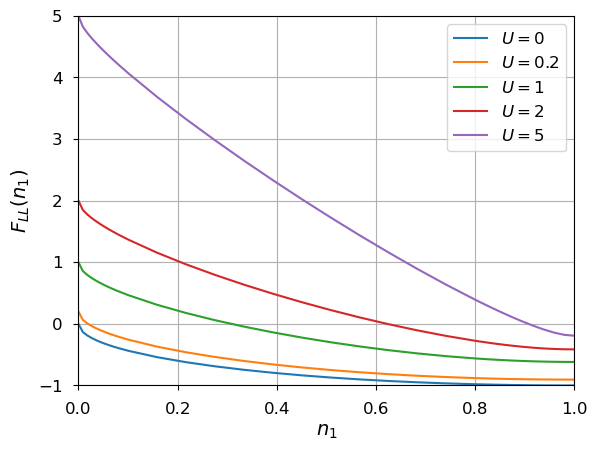

In [10]:
import matplotlib.pylab as plt

plt.xlim(0, 1)
plt.ylim(-1, 5)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)

for i in range(len(U_array) - 1):
    plt.plot(n_array, fll[i], label=f'$U = {U_array[i]}$')

plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'
plt.legend(prop = {'size': 12})


Due to the symmetry of the lattice, the Levy-Lieb functional is symmetrical about $n_{1}$ = 1. To expand our data to $1 < n_{1} < 2$, we can take the mirror image of our obtained dataset. Furthermore, for the sake of time, let's just interpolate the dataset and call the interpolated values when calling $F_{LL}(\mathbf{n})$ in future.

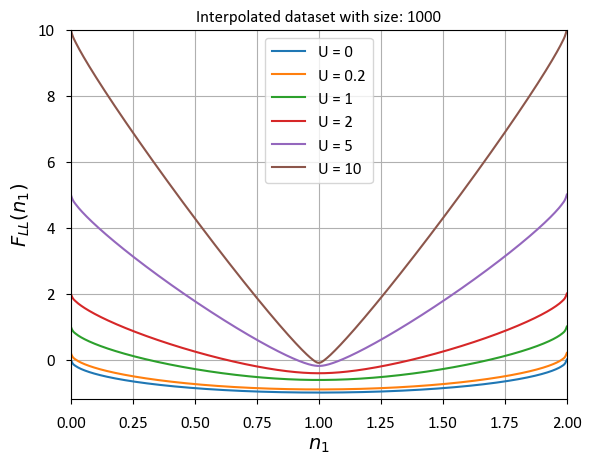

In [11]:
from scipy.interpolate import interp1d

# We want to extrapolate the data beyond n = 1 by taking the mirror image.
# The mirrored density array is
n_mirrored = n_array.copy()
for i in reversed(range(len(n_array[:-1]))):
    n_mirrored = np.append(n_mirrored, 2 - n_array[i])

# The mirrored Levy-Lieb functional data
fll_mirrored = []
for row in fll:
    fll_mirrored.append(row[:])
    fll_mirrored[-1].extend(reversed(row[:-1]))


def FLL_interp(n1, U):
    """
    Interpolates the mirrored dataset generated by density constrained VQE.
    Args:
        n1 (float): first lattice site occupation
        U (float): interaction energy parameter
    Returns:
        float
    """
    u_index = U_array.index(U) # Access index of fll dataset
    f = interp1d(n_mirrored, fll_mirrored[u_index],
                axis=-1, kind='cubic', fill_value='extrapolate')
    return f(n1)

# Plot the new interpolated dataset
plt.title('Interpolated dataset with size: 1000')
plt.xlim(0, 2)
plt.ylim(-1.2, 10)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)

for i in range(len(U_array)):
    plt.plot(np.linspace(0, 2, 1000), FLL_interp(np.linspace(0, 2, 1000), U_array[i]), label=f"U = {U_array[i]}")

plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'
plt.legend(prop = {'size': 12})


We now optimize $E(\mathbf{v}) = F_{LL}(\mathbf{n}) + \mathbf{v} \cdot \mathbf{n}$ subject to the constraint that $0 < n_{i} ≤ 2$ and $\sum_{i} n_{i} = 2$. 

In [28]:
def energy(n1, U, dv):
    """
    Calculates the energy state by calling Levy-Lieb functional

    Args:
        n1 (float): first lattice site occupation
        U (float): interaction energy parameter
        dv (float): onsite, symmetric potential snergy difference
    Returns:
        float
    """
    #  Consider the symmetric dimer
    v1 = -dv / 2
    v2 = dv / 2
    return FLL_interp(n1, U) + n1 * v1  + (2 - n1) * v2


def E_ground(U, dv):
    """
    Calculates the energy of the ground state by minimising the energy function wrt density, n1 using an SLSQP optimiser.

    Args:
        U (float): interaction energy parameter
        dv (float): onsite, symmetric potential energy difference
    Returns:
        float
    """
    ## Step 1 - Find initial density guess for minimisation routine
    n_guess = 0                           
    E_guess = energy(n_guess, U, dv)

    # Briefly cycle through 13 values of n, compute energy and set initial guess at minimum
    for n1 in np.linspace(0.14, 2, 13):   
        E_n1 = energy(n1, U, dv)        
        
        if E_n1 < E_guess:
            E_guess = E_n1               
            n_guess = n1                 

    ## Step 2 - Minimise Energy function to find ground state 
    constraints = [{'type': 'ineq', 'fun': lambda x : 2 - x},  
                  {'type': 'ineq', 'fun': lambda x : x}]      

    min_E = minimize(fun = energy,                            
                     x0 = n_guess,                             
                     args = (U, dv),
                     constraints = constraints,                
                     method = 'SLSQP', 
                      )
    return min_E.fun

In [30]:
# Calculate the ground energy for 40 values of dv, for each value of U
dv_array = np.linspace(0, 20, 40)
E = []

for i in range(1, len(U_array)):
    E_list = []
    for dv in dv_array:
        E_g = E_ground(U_array[i], dv)
        E_list.append(E_g)

    E.append(E_list)

We will compare our results to that of the exact ground state. This can be calculated by calculating the eigenvalues of the matrix representation of the Hamiltonian in the basis set, $|1 ↑ 1 ↓ \rangle$, $|1 ↑ 2 ↓ \rangle$, $|1 ↓ 2 ↑ \rangle$, $|2 ↑ 2 ↓ \rangle$ [2]:

\begin{equation}
\hat{H} = \begin{bmatrix}
    2v_1 + U & -t & t & 0 \\
    -t & 0 & 0 & -t \\
    t & 0 & 0 & t \\
    0 & -t & t & 2v_2 + U
\end{bmatrix}
\end{equation}


In [31]:
from numpy import linalg

def exact_E_ground(t, U, dv):
    """
    Calculates the exact eigenvalues of the symmetric dimer.

    Args:
        t (float): tunnelling amplitude
        U (float): interaction energy parameter
        dv (float): symmetric potential energy difference
    Returns:
        float
    """
    # The Hamiltonian for a symmetric dimer. 
    v1 = -dv/2
    v2 = dv/2
    H = np.array([[2 * v1 + U, -t,       t,  0],
                  [-t,          0,       0, -t],
                  [t,           0,       0,  t],
                  [0,          -t,       t,  2 * v2 + U]])    
    
    eigenvalues = np.real(linalg.eig(H)[0]) 
    return min(eigenvalues)

dv_array2 = np.linspace(0, 20, 3 * len(dv_array)) 
exact_E_arrays = []

for i in range(1, len(U_array)):    
    list = []
    for dv in dv_array2:
        list.append(exact_E_ground(0.5, U_array[i], dv))

    exact_E_arrays.append(list)

In [32]:
# Take the difference between exact Energy calculations and dataset to calculate relative absolute error
Errors = []
for i in range(len(exact_E_arrays)):
    error_list = []
    for j in range(len(E[0])):
        error_list.append(abs( (exact_E_arrays[i][j*3] - E[i][j])/ exact_E_arrays[i][j*3] ))
    Errors.append(error_list)

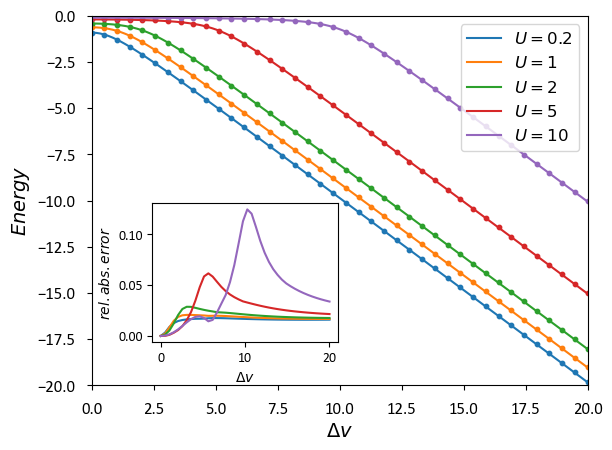

In [33]:
# Plot the ground energy for different values of U and n1
import matplotlib.pyplot as plt

fig, ax_main = plt.subplots()
for i in range(len(E)):
    ax_main.scatter(dv_array, E[i], s = 10)
    ax_main.plot(dv_array2, exact_E_arrays[i], label = f'$U = {U_array[i + 1]}$')
plt.legend(loc = 1, prop = {'size':12})
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)

left, bottom, width, height = 0.22, 0.2, 0.29, 0.29
ax_small = fig.add_axes([left, bottom, width, height])
for i in range(len(Errors)):
    ax_small.plot(dv_array, Errors[i])
ax_small.set_xlabel(r'$\Delta v$')
ax_small.set_ylabel(r'$rel. abs. error$')
ax_main.set_xlim(0, 20)
ax_main.set_ylim(-20, 0)
ax_main.set_xlabel(r'$\Delta v$',  fontdict={'fontsize': 14})
ax_main.set_ylabel(r'$Energy$',  fontdict={'fontsize': 14})
plt.show()

## References
1. C. D. Pemmaraju and A. Deshmukh, “Levy-lieb embedding of density-functional theory and its quantum kernel: Illustration for the hubbard dimer using near-term quantum algorithms,” Physical Review A, vol. 106, no. 4, 2022. doi:10.1103/physreva.106.042807.

2. D. J. Carrascal, J. Ferrer, J. C. Smith, and K. Burke, “The Hubbard Dimer: A density functional case study of a many-body problem,” Journal of Physics: Condensed Matter, vol. 27, no. 39, p. 393001, Sep. 2015. doi:10.1088/0953-8984/27/39/393001 